# Georgia and Florida Reopening Among COVID-19 Concerns

## Applied Data Science Capstone by IBM/Coursera

## Table of Contents
<a href='#Introduction'>Introduction</a><br>
<a href='#Methodology'>Methodology</a><br>
<a href='#Results'>Results</a><br>
<a href='#Discussion'>Discussion</a><br>
<a href='#Conclusion'>Conclusion</a><br>
<a href='#Appendix'>Appendix</a>

## Introduction/Business Problem
There are cities like Jacksonville reopening beaches while Georgia is planning to reopen several businesses starting April 24th. Is this a good time to consider reopening with the risk to public health from  COVID-19 or will there be too much economic damage if not? In order to answer the questions, I will take a look at county health population information from https://www.countyhealthrankings.org/ and business information(leveraging Foursquare API)in Jacksonsville, Florida and compare to Savannah, Georgia since they are large cities located in the neighboring states. The governers of Georgia and Florida should take these factors into consideration before opening their states among COVID-19.

## Data
<b>I. Neighborhood Locations</b> <br>
I will be using http://www.city-data.com to get neighborhoods and geographical locations. 

<b>II. Foursquare Location API</b> <br>
I will explore business information such as number and type of businesses to see the type of impact closing the cities will have. I also want to see if there are nearby clinics, hospitals, and/or pharmacies to learn about capacity for handling rise in cases for decision in reopening. 

<b>III. County Health Rankings</b> <br>
I will be using county health rankings to get details about the population using information such as:
- Quality of Life
- Health Behaviors
- Clinical Care
- Social & Economic Factors

<b>IV. Death Rates by Age</b> <br>
I will be using https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/ to get 
death rates by age. 

<b>V. Hospital Capacities</b> <br>
I will be using https://coronavirus.jhu.edu/us-map to get deaths, confirmed cases, and hospital capacity by county. 

## Methodology
<a id='Methodology'></a>

<b>I. Access Foursquare API</b><br>
In order to determine number and/or type of businesses affected, we need to explore Jacksonville and Savannah counties. We will access the Foursquare API to get business information 
but first need to find all the nearby neighborhoods with geographical coordinates in each city. 

**Import necessary packages and libraries.** 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

In [2]:
conda update -n base conda

In [3]:
# conda install -c anaconda beautifulsoup4

In [4]:
import requests
from bs4 import BeautifulSoup
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
import re

**Generate credentials to access API.**

In [5]:
CLIENT_ID = 'KTOGVYYQUEWMCLZYN3EHY3W1FJ2EUDJ1FIXZKSXQCWBXNQJA' # your Foursquare ID
CLIENT_SECRET = '01RRALCQSNM3UZKYRWZYBNMJL5O5TBFCCBRVKYI4XUA0MSWW' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KTOGVYYQUEWMCLZYN3EHY3W1FJ2EUDJ1FIXZKSXQCWBXNQJA
CLIENT_SECRET:01RRALCQSNM3UZKYRWZYBNMJL5O5TBFCCBRVKYI4XUA0MSWW


**Create function for getting neighborhood coordinates by city. The function webscrapes city-data.com to get neighborhood information by city.**

In [6]:
def get_neigborhood(URL,city):
#     URL = 'http://www.city-data.com/nbmaps/neigh-Savannah-Georgia.html'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser') 
    city_name = [tag.text for tag in soup.find_all('a',href=re.compile(r'#N\d+'))] 
    string=(','+ city)
    city_names=[x + string for x in city_name]
    column_names = ['Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    neighborhoods = pd.DataFrame(columns=column_names)
    #apply Nominatim
    geolocator = Nominatim(user_agent="to_explorer")
 
    for i in city_names:
        try:
            location = geolocator.geocode(i)
            latitude = location.latitude 
            longitude = location.longitude 
            neighborhoods = neighborhoods.append({'Neighborhood': i,
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)  
        except AttributeError:
            continue 

    # making separate first name column from new data frame 
    new = neighborhoods["Neighborhood"].str.split(",", n = 1, expand = True) 
    neighborhoods["Neighborhood"]= new[0] 
  
    # making separate last name column from new data frame 
    neighborhoods["City"]= new[1] 
    neighborhoods2 = neighborhoods[["City", "Neighborhood", "Latitude","Longitude"]]


    return neighborhoods2

**Call function by city to get all neighborhoods, latitude,and longitude.**<br>
Let's start with Savannah. 

In [7]:
Jacksonville='http://www.city-data.com/nbmaps/neigh-Jacksonville-Florida.html'
Savannah='http://www.city-data.com/nbmaps/neigh-Savannah-Georgia.html'
neighborhoods=get_neigborhood(Jacksonville,city='Jacksonville')
# neighborhoods=get_neigborhood(Savannah,city='Savannah')
# 'http://www.city-data.com/nbmaps/neigh-Jacksonville-Florida.html',city='Jacksonville'


In [19]:
neighborhoods.head()

,City,Neighborhood,Latitude,Longitude
0,Savannah,Avalon,32.050010,-81.066843
1,Savannah,Avondale,32.052988,-81.057612
2,Savannah,Baldwin Park,32.050870,-81.091097
3,Savannah,Bartow,32.086596,-81.124556
4,Savannah,Bayview,30.224534,-85.682356


**Next Jacksonville neighborhoods and coordinates.**

In [8]:
neighborhoods.head()

,City,Neighborhood,Latitude,Longitude
0,Jacksonville,Arlington,30.335795,-81.602871
1,Jacksonville,Avondale,30.304406,-81.711209
2,Jacksonville,Belfort Station,30.251119,-81.584455
3,Jacksonville,Brooklyn,30.323573,-81.674541
4,Jacksonville,Church District,30.280525,-81.490998


**Use function to get nearby venues.** 

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Create simple variable to assign different cities.**

In [22]:
A='Savannah'

In [28]:
A_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [27]:
A_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Avalon,32.05001,-81.066843,GameStop,32.044100,-81.068130,Video Game Store
1,Avalon,32.05001,-81.066843,Whole Foods Market,32.043391,-81.071361,Grocery Store
2,Avalon,32.05001,-81.066843,Hop Xing,32.044566,-81.067693,Chinese Restaurant
3,Avalon,32.05001,-81.066843,Firehouse Subs,32.041880,-81.066176,Sandwich Place
4,Avalon,32.05001,-81.066843,Sisters Of The New South,32.042652,-81.063602,Restaurant


In [11]:
A='Jacksonville'
A_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Arlington
Avondale
Belfort Station
Brooklyn
Church District
Downtown
East Jacksonville
Empire Point
Mandarin
North Jacksonville
Oakland
Ortega
River Park
Riverside
San Marco
Sherwood Forest
South Jacksonville
South Side
Springfield
Stadium District
Waterleaf
West Jacksonville


In [11]:
A_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(A_venues['Venue Category'].unique())))

There are 193 uniques categories.


In [12]:
A_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(A_venues['Venue Category'].unique())))

There are 140 uniques categories.


**One-hot Encoding for Generating Venue Frequency**

In [13]:
# one hot encoding
A_onehot = pd.get_dummies(A_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
A_onehot['Neighborhood'] = A_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [A_onehot.columns[-1]] + list(A_onehot.columns[:-1])
A_onehot = A_onehot[fixed_columns]

A_onehot.head()

,Neighborhood,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Garden,Boat or Ferry,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Dentist's Office,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Electronics Store,Exhibit,Fast Food Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gaming Cafe,Garden Center,Gas Station,Gay Bar,General Entertainment,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Heliport,Historic Site,History Museum,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Lawyer,Light Rail Station,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Movie Theater,Music Venue,New American Restaurant,Nightclub,Other Great Outdoors,Outdoors & Recreation,Park,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pub,Record Shop,Rental Car Location,Resort,Rest Area,Restaurant,Salon / Barbershop,Sandwich Place,Shipping Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Video Store,Vietnamese Restaurant,Volleyball Court,Wings Joint,Zoo
0,Arlington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arlington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arlington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arlington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Arlington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [30]:
# one hot encoding
A_onehot = pd.get_dummies(A_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
A_onehot['Neighborhood'] = A_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [A_onehot.columns[-1]] + list(A_onehot.columns[:-1])
A_onehot = A_onehot[fixed_columns]

A_onehot.head()

,Yoga Studio,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Café,Campground,Candy Store,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moving Target,Multiplex,Museum,Neighborhood,New American Restaurant,Nightclub,Noodle House,Optical Shop,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pub,Record Shop,Rental Car Location,Restaurant,River,Road,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Track,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Winery,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Avalon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Avalon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Avalon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
#Savannah
A_grouped = A_onehot.groupby('Neighborhood').mean().reset_index()
A_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Café,Campground,Candy Store,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moving Target,Multiplex,Museum,New American Restaurant,Nightclub,Noodle House,Optical Shop,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pub,Record Shop,Rental Car Location,Restaurant,River,Road,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Track,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Winery,Wings Joint,Women's Store
0,Avalon,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.033333,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.033333,0.033333,0.0,0.0,0.066667,0.000000,0.000000,0.000000,0.000000,0.0,0.033333,0.033333,0.0,0.0,0.000000,0.066667,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Avondale,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.071429,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0

In [14]:
#Jacksonville
A_grouped = A_onehot.groupby('Neighborhood').mean().reset_index()
A_grouped.head()

,Neighborhood,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Garden,Boat or Ferry,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Dentist's Office,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Electronics Store,Exhibit,Fast Food Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gaming Cafe,Garden Center,Gas Station,Gay Bar,General Entertainment,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Heliport,Historic Site,History Museum,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Lawyer,Light Rail Station,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Movie Theater,Music Venue,New American Restaurant,Nightclub,Other Great Outdoors,Outdoors & Recreation,Park,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pub,Record Shop,Rental Car Location,Resort,Rest Area,Restaurant,Salon / Barbershop,Sandwich Place,Shipping Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Video Store,Vietnamese Restaurant,Volleyball Court,Wings Joint,Zoo
0,Arlington,0.043478,0.043478,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.043478,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.043478,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.043478,0.000000,0.0,0.000000,0.000000,0.043478,0.0,0.000000,0.00,0.000000,0.0,0.0,0.043478,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,0.043478,0.0,0.000000,0.000000,0.043478,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.0,0.000000,0.043478,0.0,0.000000,0.000000,0.043478,0.00,0.0,0.000000,0.043478,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.043478,0.0,0.0,0.043478,0.000000,0.043478,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.00,0.043478,0.00,0.00,0.043478,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.043478,0.0,0.0,0.086957,0.00,0.0,0.000000,0.0
1,Avondale,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.041667,0.000000,0.041667,0.0,0.0,0.0,0.0,0.000000,0.041667,0.041667,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.041667,0.000000,0.041667,0.0,0.000000,0.000000,0.041667,0.0,0.041667,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.041667,0.000000,0.0,0.041667,0.041667,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.0,0.041667,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.041667,0.0,0.0,0.0,0.00,0.0,0.000000,0.041667,0.0,0.0,0.000000,0.041667,0.000000,0.0,0.0,0.041667,0.0,0.00,0.0,0.083333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.00,0.000000,0.00,0.00,0.000000,0.083333,0.000000,0.0,0.0,0.00,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.041667,0.0
2,Belfort Station,0.000000,0.000000,0.055556,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.055556,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.055556,0.055556,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000

### Savannah Venue Frequency

In [34]:
num_top_venues = 10
for hood in A_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = A_grouped[A_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In East Savannah, pizza places(18%) and discount stores(18%) account for 36% of venues. In Southover, Savannah bakeries(25%), breweries(25%), and discount stores(25%) account for 75% of venues.

For output go to 
<a href='#Savannah_Venue'>Savannah_Venue</a>

### Jacksonville Venue Frequency

In [16]:
num_top_venues = 10
for hood in A_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = A_grouped[A_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

*In North Jacksonville and East Jacksonville, fast food restaurants account for about 38% of venues. In East Savannah, pizza places(18%) and discount stores(18%) account for 36% of venues. In Southover, Savannah bakeries(25%), breweries(25%), and discount stores(25%) account for 75% of venues.* 

For output go to 
<a href='#Jacksonville_Venue'>Jacksonville_Venue</a>

**Get most common revenues and place in dataframe.**

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Savannah Top 10 Revenues**

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
A_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
A_neighborhoods_venues_sorted['Neighborhood'] = A_grouped['Neighborhood']

for ind in np.arange(A_grouped.shape[0]):
    A_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(A_grouped.iloc[ind, :], num_top_venues)

A_neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Avalon,Mobile Phone Shop,Pizza Place,Chinese Restaurant,Mexican Restaurant,Sandwich Place,Hardware Store,Fried Chicken Joint,Breakfast Spot,Fast Food Restaurant,Rental Car Location
1,Avondale,Park,Food,Sporting Goods Shop,Tour Provider,Seafood Restaurant,Fast Food Restaurant,Skating Rink,Liquor Store,General Travel,Convenience Store
2,Baldwin Park,Gas Station,Park,Intersection,Playground,Southern / Soul Food Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Salon / Barbershop,Sporting Goods Shop
3,Bartow,Pet Store,Discount Store,Grocery Store,Seafood Restaurant,American Restaurant,Park,Chinese Restaurant,Shipping Store,Food & Drink Shop,Food
4,Bayview,Construction & Landscaping,Garden,Kids Store,Drive-in Theater,Women's Store,Electronics Store,French Restaurant,Fountain,Food Truck,Food & Drink Shop
5,Beach Institute,Plaza,Park,Bed & Breakfast,Hotel Bar,Tea Room,Hotel,Italian Restaurant,Fountain,Farmers Market,Dive Bar
6,Berkshire Woods,Park,Home Service,Photography Studio,Coffee Shop,Women's Store,Drive-in Theater,Fountain,Food Truck,Food & Drink Shop,Food
7,Bingville,Convenience Store,Park,Discount Store,Mexican Restaurant,Electronics Store,Bar,Fast Food Restaurant,Bistro,Chinese Restaurant,Grocery Store
8,Blueberry Hill,Farm,Women's Store,Wings Joint,Fried Chicken Joint,French Restaurant,Fountain,Food Truck,Food & Drink Shop,Food,Fast Food Restaurant
9,Brookview,Chinese Restaurant,Intersection,Construction & Landscaping,Furniture / Home Store,Food & Drink Shop,Food,Golf Course,Thrift / Vintage Store,Southern / Soul Food Restaurant,Farm


**Jacksonville Top 10 Revenues**

In [18]:
#Jacksonville
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
A_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
A_neighborhoods_venues_sorted['Neighborhood'] = A_grouped['Neighborhood']

for ind in np.arange(A_grouped.shape[0]):
    A_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(A_grouped.iloc[ind, :], num_top_venues)

A_neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arlington,Video Store,Restaurant,ATM,Italian Restaurant,Mexican Restaurant,Shopping Mall,Seafood Restaurant,Sandwich Place,Fried Chicken Joint,Bookstore
1,Avondale,Park,Pizza Place,Convenience Store,Gaming Cafe,Plaza,Deli / Bodega,New American Restaurant,Coffee Shop,Chinese Restaurant,Smoke Shop
2,Belfort Station,Hotel,Sandwich Place,Automotive Shop,Cocktail Bar,Chinese Restaurant,Food Truck,Gas Station,Japanese Restaurant,Italian Restaurant,Mexican Restaurant
3,Brooklyn,Café,Park,Deli / Bodega,Gym / Fitness Center,Gym,Smoothie Shop,Sandwich Place,Concert Hall,Plaza,Playground
4,Church District,Grocery Store,Pizza Place,Japanese Restaurant,Intersection,Spa,Shopping Mall,Pharmacy,Liquor Store,Shipping Store,Sandwich Place
5,Downtown,Bakery,History Museum,Truck Stop,Gas Station,Bar,Italian Restaurant,Greek Restaurant,Rest Area,American Restaurant,Dive Bar
6,East Jacksonville,Fast Food Restaurant,Video Store,Light Rail Station,Train Station,Sandwich Place,Bakery,Zoo,Event Service,Flea Market,Farmers Market
7,Empire Point,Chiropractor,Lawyer,American Restaurant,Rental Car Location,Gas Station,Baseball Field,Donut Shop,Flea Market,Fast Food Restaurant,Farmers Market
8,Mandarin,Event Service,Pet Store,Business Service,Farmers Market,Park,Food Truck,Flea Market,Fast Food Restaurant,Exhibit,Zoo
9,North Jacksonville,Fast Food Restaurant,Video Store,Light Rail Station,Train Station,Sandwich Place,Bakery,Zoo,Event Service,Flea Market,Farmers Market


**Read CSV Files with Table Information**

In [1]:
pip install xlrd

     |████████████████████████████████| 103 kB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pwd

'/home/jovyan/demo'

In [4]:
import pandas as pd
County_Table= pd.read_csv('/home/jovyan/demo/County_Health_Rankings.csv')

**II. Import County Health Rankings Table**<br>
Reference:https://www.countyhealthrankings.org/app/georgia/2020/compare/snapshot?counties=12_031%2013_051

In [16]:
County_Table[County_Table.isnull()]=""
County_Table.head()

,Unnamed: 0,"Duval (DU) , FL","Chatham (CA) , GA"
0,Demographics,,
1,Population,"950,181","289,195"
2,% below 18 years of age,22.60%,21.20%
3,% 65 and older,14.00%,15.40%
4,% Non-Hispanic Black,29.50%,40.10%


**III. Import Death by Age Table**<br>
Reference:https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/<br>
As of May 13th

In [ ]:
Death_by_Age_Table= pd.read_csv('/home/jovyan/demo/Death_By_Age_Coronavirus.csv')

**IV. Import Fatalaties and Hospital Capacities**<br>
Reference:https://bao.arcgis.com/covid-19/jhu/county/13051.html

In [6]:
Capacity_Table= pd.read_csv('/home/jovyan/demo/Hospital_Capacity.csv')

## Results
<a id='Results'></a>

**Table 1. Savannah Venues**

In [19]:
Savannah_data=A_neighborhoods_venues_sorted
Savannah_data

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Avalon,Mobile Phone Shop,Pizza Place,Chinese Restaurant,Sandwich Place,Mexican Restaurant,Restaurant,Big Box Store,Breakfast Spot,Fast Food Restaurant,Hardware Store
1,Avondale,Park,Sporting Goods Shop,General Travel,Convenience Store,Historic Site,Seafood Restaurant,Skating Rink,Fast Food Restaurant,Food,Liquor Store
2,Baldwin Park,Gas Station,Park,Intersection,Playground,American Restaurant,Southern / Soul Food Restaurant,Salon / Barbershop,Sporting Goods Shop,Liquor Store,Lounge
3,Bartow,Pet Store,Park,Discount Store,Food,Business Service,Seafood Restaurant,Chinese Restaurant,Grocery Store,Mobile Phone Shop,American Restaurant
4,Bayview,Garden,Kids Store,Drive-in Theater,Women's Store,Donut Shop,Food & Drink Shop,Food,Flower Shop,Fish Market,Fast Food Restaurant
5,Beach Institute,Plaza,Bed & Breakfast,Park,Southern / Soul Food Restaurant,Hotel,Italian Restaurant,Dive Bar,Bakery,Tea Room,BBQ Joint
6,Berkshire Woods,Park,Home Service,Photography Studio,Coffee Shop,Donut Shop,Food,Flower Shop,Fish Market,Fast Food Restaurant,Farmers Market
7,Bingville,Convenience Store,Park,Discount Store,Wings Joint,Grocery Store,General Entertainment,Fast Food Restaurant,Mexican Restaurant,Electronics Store,Bar
8,Blueberry Hill,Farm,Women's Store,Wings Joint,Food Truck,Food & Drink Shop,Food,Flower Shop,Fish Market,Fast Food Restaurant,Farmers Market
9,Brookview,Chinese Restaurant,Intersection,Construction & Landscaping,Food,Furniture / Home Store,Golf Course,Food & Drink Shop,Thrift / Vintage Store,Southern / Soul Food Restaurant,Electronics Store


**Table 2. Jacksonville Venues**

In [19]:
Jacksonville_data=A_neighborhoods_venues_sorted
Jacksonville_data

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arlington,Video Store,Restaurant,ATM,Italian Restaurant,Mexican Restaurant,Shopping Mall,Seafood Restaurant,Sandwich Place,Fried Chicken Joint,Bookstore
1,Avondale,Park,Pizza Place,Convenience Store,Gaming Cafe,Plaza,Deli / Bodega,New American Restaurant,Coffee Shop,Chinese Restaurant,Smoke Shop
2,Belfort Station,Hotel,Sandwich Place,Automotive Shop,Cocktail Bar,Chinese Restaurant,Food Truck,Gas Station,Japanese Restaurant,Italian Restaurant,Mexican Restaurant
3,Brooklyn,Café,Park,Deli / Bodega,Gym / Fitness Center,Gym,Smoothie Shop,Sandwich Place,Concert Hall,Plaza,Playground
4,Church District,Grocery Store,Pizza Place,Japanese Restaurant,Intersection,Spa,Shopping Mall,Pharmacy,Liquor Store,Shipping Store,Sandwich Place
5,Downtown,Bakery,History Museum,Truck Stop,Gas Station,Bar,Italian Restaurant,Greek Restaurant,Rest Area,American Restaurant,Dive Bar
6,East Jacksonville,Fast Food Restaurant,Video Store,Light Rail Station,Train Station,Sandwich Place,Bakery,Zoo,Event Service,Flea Market,Farmers Market
7,Empire Point,Chiropractor,Lawyer,American Restaurant,Rental Car Location,Gas Station,Baseball Field,Donut Shop,Flea Market,Fast Food Restaurant,Farmers Market
8,Mandarin,Event Service,Pet Store,Business Service,Farmers Market,Park,Food Truck,Flea Market,Fast Food Restaurant,Exhibit,Zoo
9,North Jacksonville,Fast Food Restaurant,Video Store,Light Rail Station,Train Station,Sandwich Place,Bakery,Zoo,Event Service,Flea Market,Farmers Market


**Table 3. County Health Rankings**<br>
Reference: https://www.countyhealthrankings.org/app/georgia/2020/compare/snapshot?counties=12_031%2013_051 

In [17]:
County_Table

,Unnamed: 0,"Duval (DU) , FL","Chatham (CA) , GA"
0,Demographics,,
1,Population,"950,181","289,195"
2,% below 18 years of age,22.60%,21.20%
3,% 65 and older,14.00%,15.40%
4,% Non-Hispanic Black,29.50%,40.10%
5,% American Indian & Alaska Native,0.50%,0.40%
6,% Asian,5.10%,2.90%
7,% Native Hawaiian/Other Pacific Islander,0.10%,0.10%
8,% Hispanic,10.10%,6.60%
9,% Non-Hispanic White,52.60%,48.20%


**Table 4. Death by Age New York**<br>
Reference:https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [8]:
Death_by_Age_Table

,AGE,Number of Deaths,Share of deaths,With underlying conditions,Without underlying conditions,Unknown if with underlying cond.,Share of deaths of unknown + w/o cond.
0,0 - 17 years old,9,0.06%,6,3,0,0.02%
1,18 - 44 years old,601,3.90%,476,17,108,0.80%
2,45 - 64 years old,"3,413",22.40%,"2,851",72,490,3.70%
3,65 - 74 years old,"3,788",24.90%,"2,801",5,982,6.50%
4,75+ years old,"7,419",48.70%,"5,236",2,"2,181",14.30%
5,TOTAL,"15,230",100%,"11,370 (75%)",99 (0.7%),"1,551 (24.7%)",25.30%


**Table 5. Capacity and Fatality Rates**<br>
Reference:https://bao.arcgis.com/covid-19/jhu/county/13051.html

In [12]:
Capacity_Table 

,Description,Duval,Chatham,Queens
0,Number of Beds,"3,456","1,569","3,210"
1,"Cases per 100,000",128,119,"2,521"
2,Confirmed Cases,"1,215",344,"57,459"
3,Deaths,32,14,"4,595"
4,Fatality Rate,2.6%,4%,8%


For all rates by county go to:
<a href='#Capacity'>Capacity</a>

## Discussion
<a id='Discussion'></a>

Based on venues in Savannah(Table 1) and Jacksonville(Table 2) there are many businesses/venues that will be significantly impacted by economic shutdown. In North Jacksonville and East Jacksonville, fast food restaurants account for about 38% of venues. In East Savannah, pizza places(18%) and discount stores(18%) account for 36% of venues while in Southover, Savannah bakeries(25%), breweries(25%), and discount stores(25%) account for 75% of venues. With so many businesses impacted will reopening be risky? If we take a look at county health rankings(Table 3), only 14-15% of the population is 65 and over indicating a small high-risk population(Table 4) with about 75% of deaths occurring in people 65+. Additionally, access to exercise opportunities are about 90% indicating the ability for most of the population to engage in immune and health boosting activities which is important to improve the obesity rate at 31%. However, we do need to factor in smoking at 20% which increases the risk for complications for Coronavirus. Is there medical capacity for handling increase in cases? According to Johns Hopkins University, capacity and fatality rates(Table 5), Duval and Chatham counties fall well below the averages of Queens, New York. Although New York was initial site, at this point Jacksonville and Savannah have relatively low numbers of infections with a significant number of beds available. 



## Conclusion
<a id='Conclusion'></a>

The governors of Jacksonville and Savannah should consider the pros and cons of opening up too soon. As Table 5 indicates, the rate of infections and fatalities are relatively low especially for Duval county of Jacksonville. Chatham county has a higher rate but still half of Queens, New York which is the epicenter of the virus. With a population of about 300K, Chatham may fare better than other counties because of the relatively small population and vulnerable population at approximately 15%(65+). Governors have considered opening places at 25% capacity but many businesses can't be profitable at such low capacity. Another suggestion is perhaps sustain stay-at-home orders for vulnerable populations. Businesses like gyms may significantly lower the risks by permitting those under 65 at full capacity with significant cleaning measures. For schools, the most vulnerable populations continue to work online while the least can go back to the classroom. Allow the least vulnerable populations to get back to work and subsidize the ones that need to stay at home.

## Appendix
<a id='Appendix'></a>

### All Savannah Neighborhoods

In [20]:
neighborhoods

,City,Neighborhood,Latitude,Longitude
0,Savannah,Avalon,32.050010,-81.066843
1,Savannah,Avondale,32.052988,-81.057612
2,Savannah,Baldwin Park,32.050870,-81.091097
3,Savannah,Bartow,32.086596,-81.124556
4,Savannah,Bayview,30.224534,-85.682356
5,Savannah,Beach Institute,32.068951,-81.089268
6,Savannah,Berkshire Woods,31.961601,-81.153999
7,Savannah,Bingville,32.046542,-81.109500
8,Savannah,Blueberry Hill,32.344312,-80.886251
9,Savannah,Brookview,32.004379,-81.074279


### All Jacksonville Neighborhoods

In [9]:
neighborhoods

,City,Neighborhood,Latitude,Longitude
0,Jacksonville,Arlington,30.335795,-81.602871
1,Jacksonville,Avondale,30.304406,-81.711209
2,Jacksonville,Belfort Station,30.251119,-81.584455
3,Jacksonville,Brooklyn,30.323573,-81.674541
4,Jacksonville,Church District,30.280525,-81.490998
5,Jacksonville,Downtown,30.326066,-81.656353
6,Jacksonville,East Jacksonville,30.365447,-81.723926
7,Jacksonville,Empire Point,30.313700,-81.615915
8,Jacksonville,Mandarin,30.160519,-81.659260
9,Jacksonville,North Jacksonville,30.365447,-81.723926


### Savannah Venue Frequency
<a id='Savannah_Venue'></a>

In [38]:
num_top_venues = 10
for hood in A_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = A_grouped[A_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Avalon----
                  venue  freq
0    Chinese Restaurant  0.07
1           Pizza Place  0.07
2    Mexican Restaurant  0.07
3     Mobile Phone Shop  0.07
4        Sandwich Place  0.07
5   Fried Chicken Joint  0.03
6  Gym / Fitness Center  0.03
7         Grocery Store  0.03
8      Greek Restaurant  0.03
9         Deli / Bodega  0.03


----Avondale----
                  venue  freq
0                  Food  0.14
1                  Park  0.14
2          Intersection  0.07
3         Historic Site  0.07
4        General Travel  0.07
5          Skating Rink  0.07
6    Seafood Restaurant  0.07
7          Liquor Store  0.07
8         Tour Provider  0.07
9  Fast Food Restaurant  0.07


----Baldwin Park----
                             venue  freq
0                      Gas Station  0.10
1                             Park  0.10
2                     Intersection  0.07
3  Southern / Soul Food Restaurant  0.07
4              American Restaurant  0.07
5                       Playground  0

### Jacksonville Venue Frequency
<a id='Jacksonville_Venue'></a>

In [15]:
num_top_venues = 10
for hood in A_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = A_grouped[A_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arlington----
                 venue  freq
0          Video Store  0.09
1                  ATM  0.04
2          Gas Station  0.04
3    Convenience Store  0.04
4       Sandwich Place  0.04
5           Restaurant  0.04
6       Discount Store  0.04
7           Donut Shop  0.04
8  Fried Chicken Joint  0.04
9            Nightclub  0.04


----Avondale----
                venue  freq
0          Smoke Shop  0.08
1         Pizza Place  0.08
2  Mexican Restaurant  0.04
3  Chinese Restaurant  0.04
4         Coffee Shop  0.04
5                Park  0.04
6          Sports Bar  0.04
7         Gaming Cafe  0.04
8             Brewery  0.04
9      Breakfast Spot  0.04


----Belfort Station----
                  venue  freq
0        Sandwich Place  0.11
1           IT Services  0.11
2                 Hotel  0.11
3    Italian Restaurant  0.06
4           Gas Station  0.06
5    Chinese Restaurant  0.06
6          Cocktail Bar  0.06
7    Mexican Restaurant  0.06
8                   Gym  0.06
9  Gym / F

In [8]:
from IPython.display import Image

<a id='Capacity'></a>

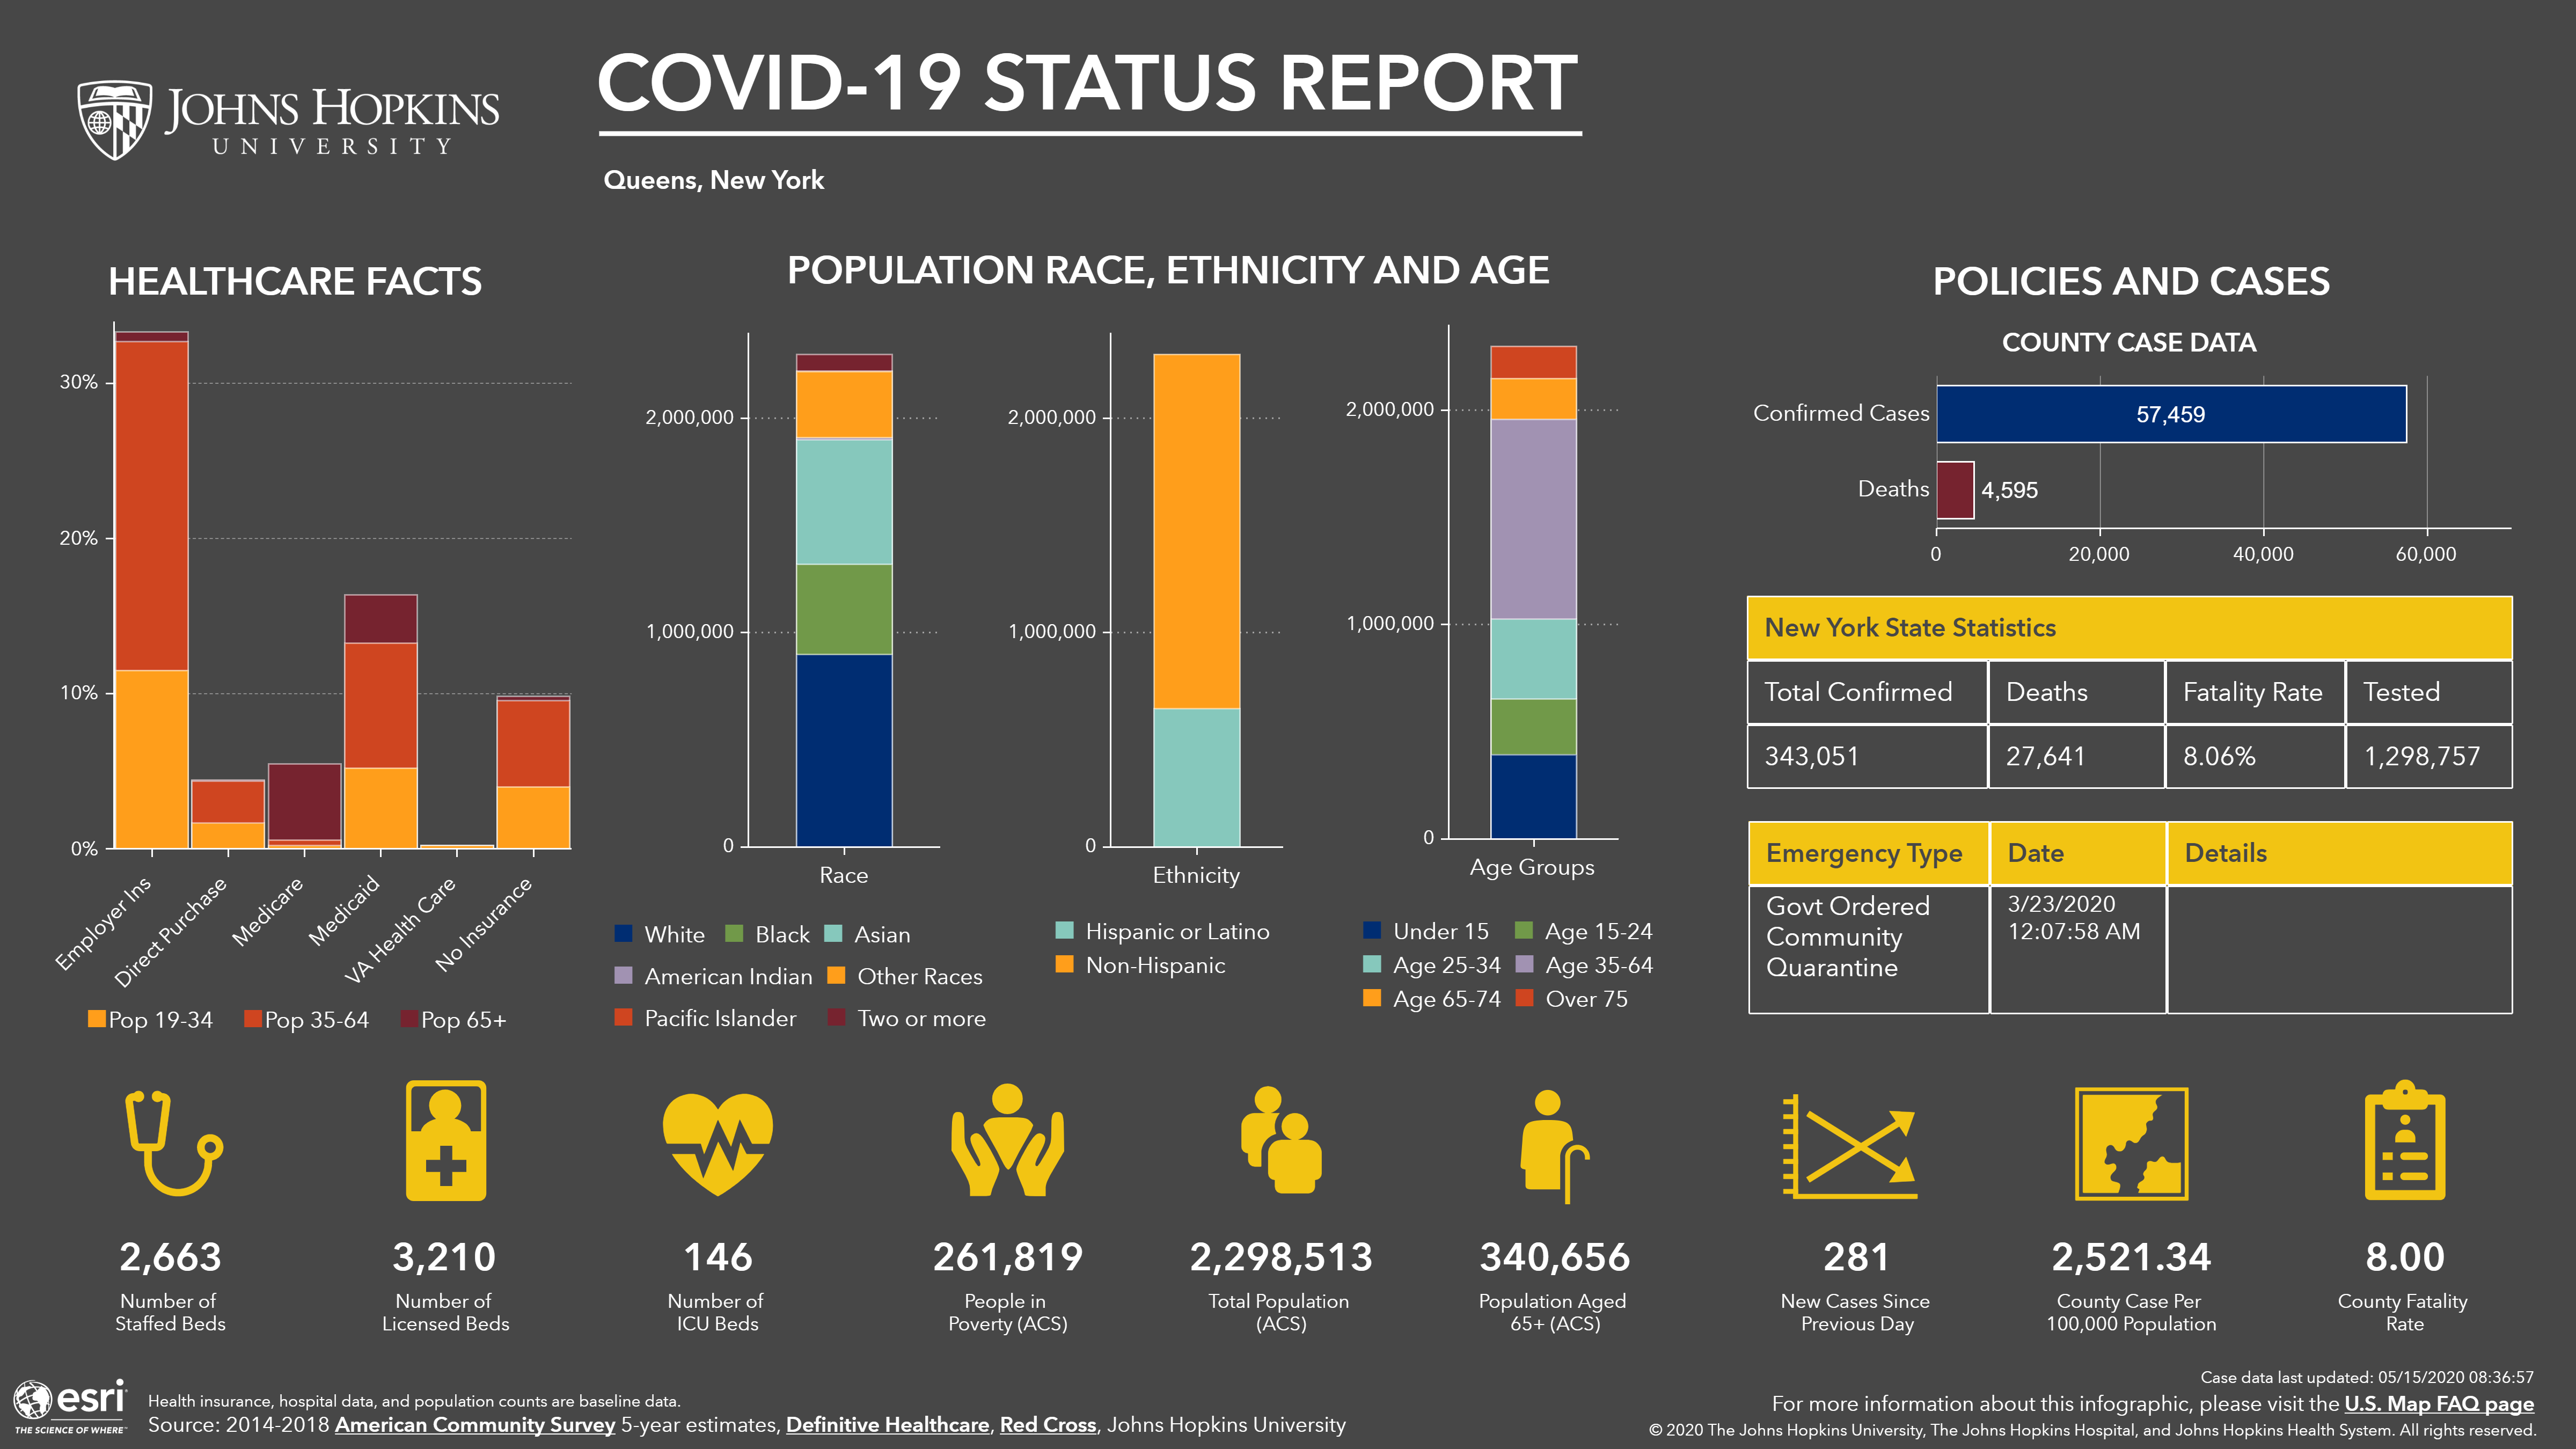

In [9]:
Queens=Image(filename='/home/jovyan/demo/JHU_COVID-19_Queens.png') 
Queens

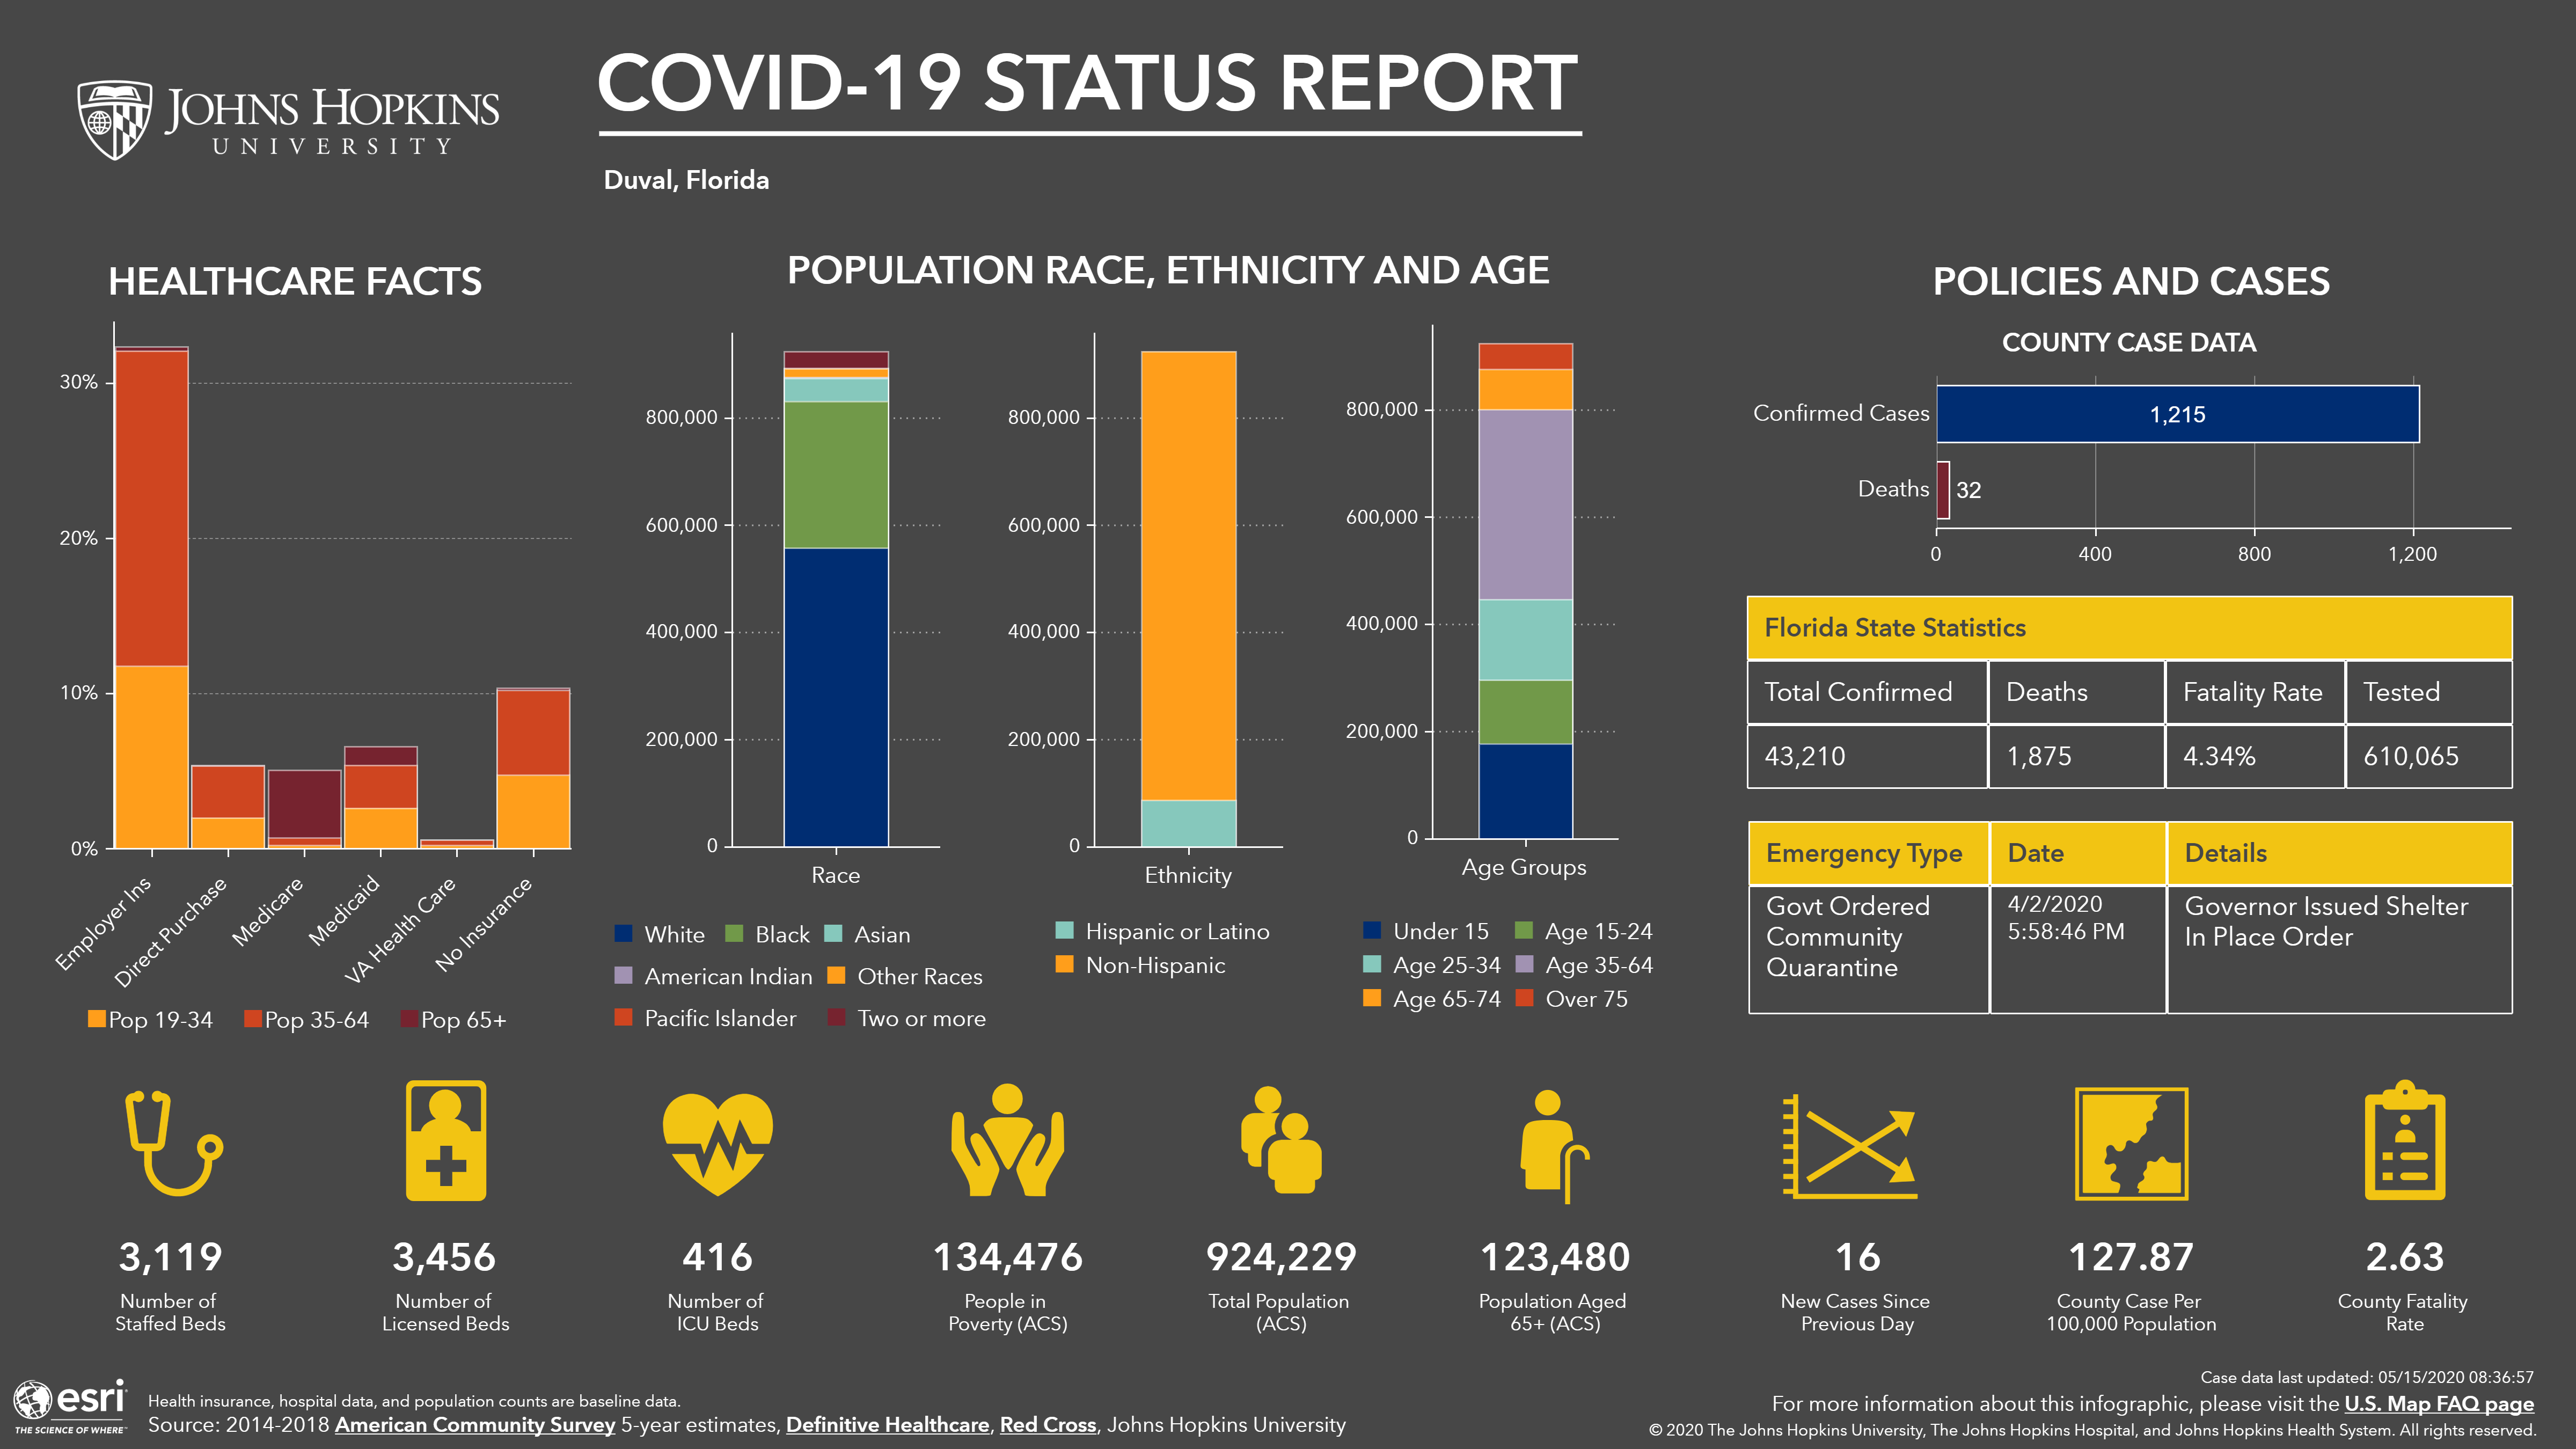

In [10]:
Duval=Image(filename='/home/jovyan/demo/JHU_COVID-19_Duval.png') 
Duval

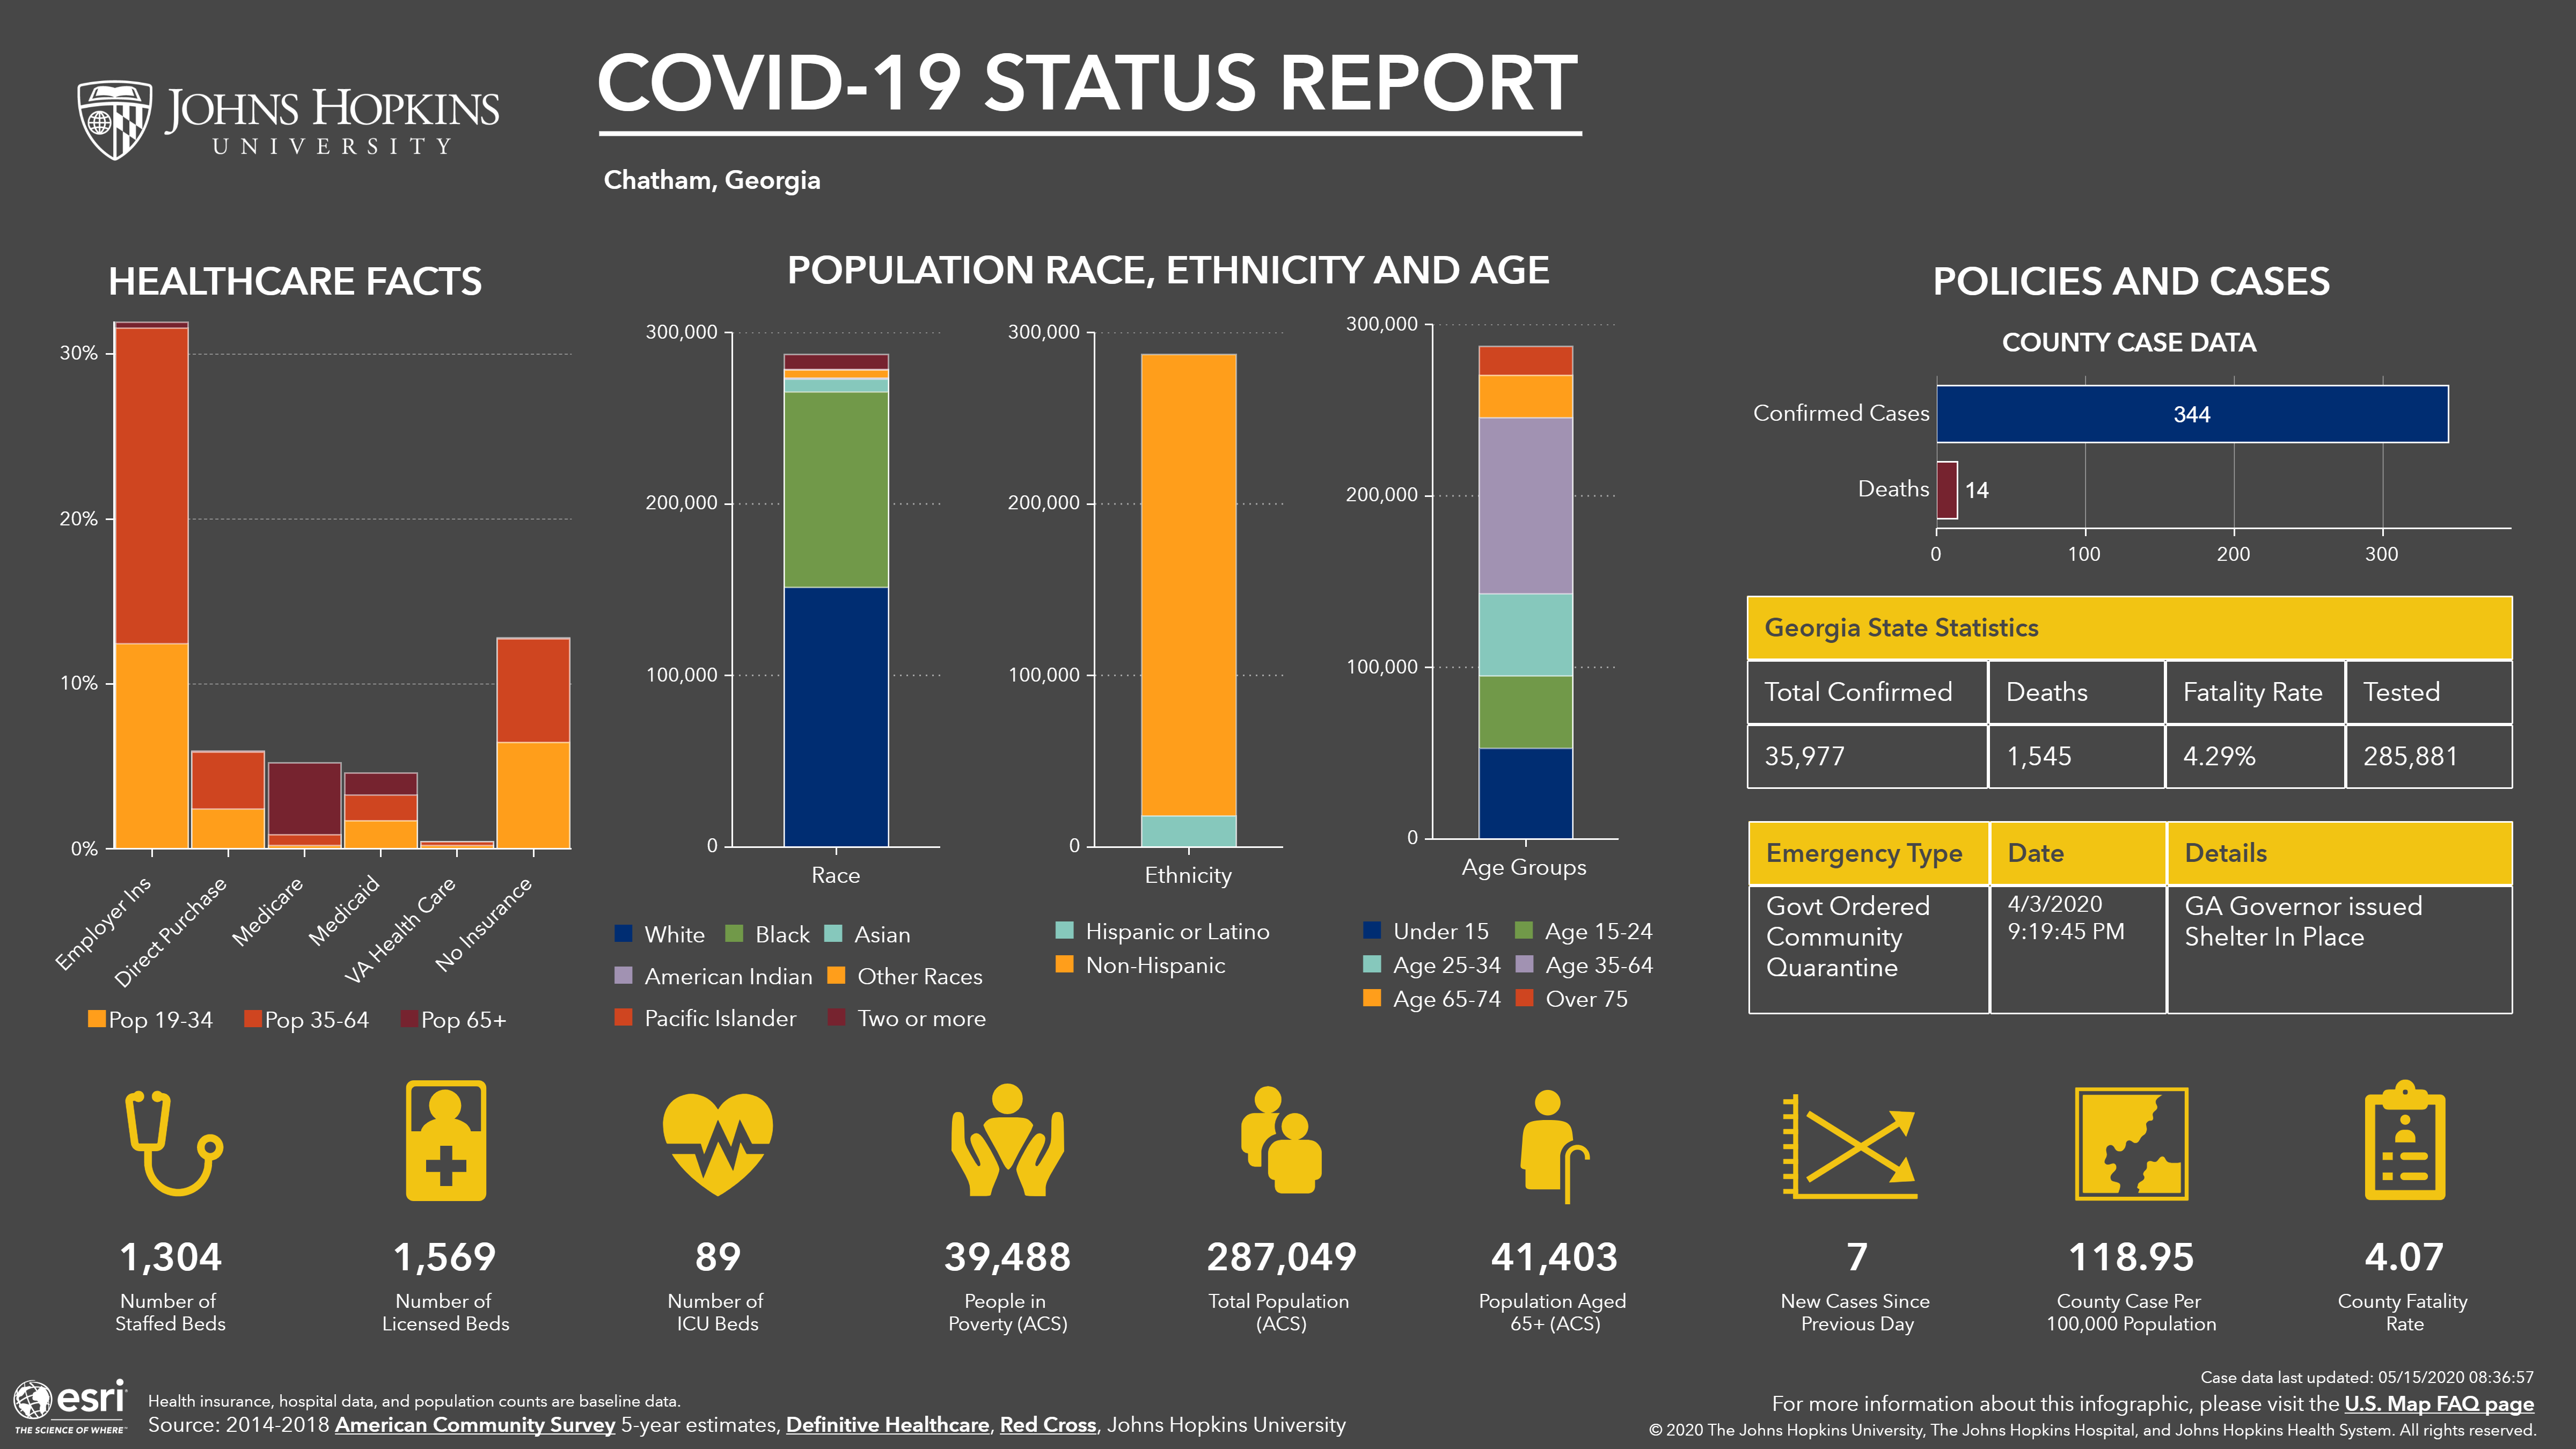

In [11]:
Chatham=Image(filename='/home/jovyan/demo/JHU_COVID-19_Chatham.png') 
Chatham